# Problem 1

## Problem Description
In this problem you will fit a neural network to solve a simple regression problem. You will use 5 fold cross validation, plotting training and validation loss curves, as well as model predictions for each of the folds. You will compare between results for 3 neural networks, trained for 100, 500, and 2000 epochs respectively.

Fill out the notebook as instructed, making the requested plots and printing necessary values. 

*You are welcome to use any of the code provided in the lecture activities.*

#### Summary of deliverables:

- Visualization of provided data
- `trainModel()` function
- 15 figures containing two subplots (loss curves and model prediction) across all 5 folds for the 3 models
- Average MSE across all folds for the 3 models
- Discussion and comparison of model performance, and the importance of cross validation for evaluating model performance.

#### Imports and Utility Functions:

In [102]:
import torch.nn as nn
import torch

import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import mean_squared_error

def plotLoss(ax, train_curve, val_curve):
    ax.plot(train_curve, label = 'Training')
    ax.plot(val_curve, label = 'Validation')
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Loss')
    ax.legend()

def plotModel(ax, model, x, y, idx_train, idx_test):
    xs = torch.linspace(min(x).item(), max(x).item(), 200).reshape(-1,1)
    ys = model(xs)
    ax.scatter(x[idx_train], y[idx_train], c = 'blue', alpha = 0.5, label = 'Training Data')
    ax.scatter(x[idx_test], y[idx_test], c = 'green', alpha = 0.5, label = 'Test Data')
    ax.plot(xs.detach().numpy(), ys.detach().numpy(), 'k--', label = 'Fitted Function')
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.legend()

## Load and visualize the data
Data can be loaded from the `m10-hw1-data.txt` file using `np.loadtxt()`. The first column of the data corresponds to the $x$ values and the second column corresponds to the $y$ values. Visualize the data using a scatter plot.

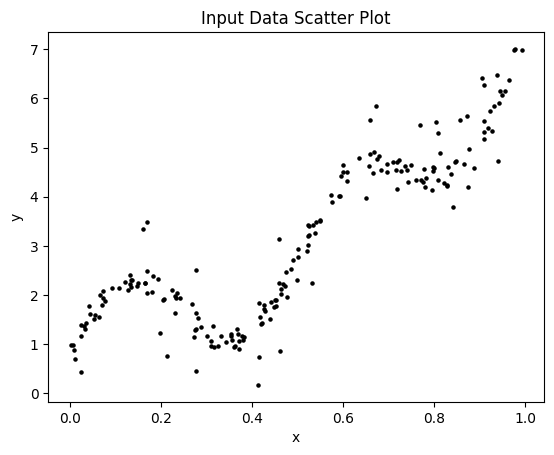

In [103]:
## YOUR CODE GOES HERE
data = np.loadtxt('data/m10-hw1-data.txt')
# data first column is x, second column is y
x = torch.tensor(data[:,0]).reshape(-1,1)
y = torch.tensor(data[:,1]).reshape(-1,1)

# plot the data using scatter plot
plt.scatter(x,y,s=5, color="black")
plt.xlabel("x")
plt.ylabel("y")
plt.title("Input Data Scatter Plot")
plt.show()

## Create Neural Network and NN Training Function

Create a neural network to predict the underlying function of the data using fully connected layers and tanh activation functions, with no activation on the output layer. The network should have 4 hidden layers, with the following shape: $[64, 128, 128, 64]$.

Since we are going to train many models throughout k-fold cross validation, you will create a function `trainModel(x, y, n_epoch)` that returns `model,train_curve,val_curve`, where `model` is the trained PyTorch model, `train_curve` and `val_curve` are lists of the training and validation loss at each epoch throughout the training, respectively. Use `nn.MSELoss()` as the loss function. Use the `torch.optim.Adam()` optimizer with a learning rate of $0.01$. You will instantiate your neural network inside of the training function, as we train a new model with each of the $k$ folds. The $x$ and $y$ which we pass the model will be split into training and validation sets using `train_test_split()` from sklearn, with a `test_size` of $0.25$. Note: since we already split the train/test data 80/20 with each $k$ fold, 25% of the remaining training data will correspond to 20% of the total data. Thus for any given fold, we have 60% of the data for training, 20% for validation, and 20% for testing.

In [104]:
## YOUR CODE GOES HERE
from torch import optim
import torch.nn.functional as F

# fully connected laters and tanh activation function, no activation function for the output layer
# 4 hidden layers with [64, 128, 128, 64]

class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(1, 64)
        self.fc2 = nn.Linear(64, 128)
        self.fc3 = nn.Linear(128, 128)
        self.fc4 = nn.Linear(128, 64)
        self.fc5 = nn.Linear(64, 1)
        self.activation = nn.Tanh()

    def forward(self, x):
        x = self.activation(self.fc1(x))
        x = self.activation(self.fc2(x))
        x = self.activation(self.fc3(x))
        x = self.activation(self.fc4(x))
        x = self.fc5(x)
        return x
    
    def trainModel(x, y, n_epoch):
        # split data into training and testing
        x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.25)
        # convert to tensor
        x_train_tensor = torch.tensor(x_train).reshape(-1,1).float()
        x_val_tensor = torch.tensor(x_val).reshape(-1,1).float()
        y_train_tensor = torch.tensor(y_train).reshape(-1,1).float()
        y_val_tensor = torch.tensor(y_val).reshape(-1,1).float()

        model = NeuralNetwork()
        lossfun = nn.MSELoss()
        opt = optim.Adam(model.parameters(), lr=0.01)

        train_curve = []
        val_curve = []

        for epoch in range(n_epoch):
            model.train()
            opt.zero_grad()
            train_pred = model(x_train_tensor)
            train_loss = lossfun(train_pred, y_train_tensor)
            train_loss.backward()
            val_pred = model(x_val_tensor)
            val_loss = lossfun(val_pred, y_val_tensor)
            val_loss.backward()
            opt.step()
            train_curve.append(train_loss.item())
            val_curve.append(val_loss.item())

        return model, train_curve, val_curve


## K-Fold Cross Validation

Now we will compare across three models trained for $[100,500,2000]$ epochs using 5-fold cross validation. We will use the `KFold()` function from sklearn to get indices of the training and test sets for the 5 folds. Then use your `trainModel()` function from the previous section to train a network for each fold. 

For each fold, generate a figure with two subplots: training and validation curves on one, and the model prediction plotted with the training and test data on the other. The training and validation curves can be generated using the provided `plotLoss()` function which takes in a subplot axes handle, `ax`, and the training and validation loss lists, `train_curve` and `val_curve`. The model prediction can be plotted using the `plotModel()` function which takes in a subplot axes handle, `ax`, the trained model, `model`, the complete datasets `x` and `y`, and `idx_train` and `idx_test`, the indices of of the training and test data for that specific fold.

The generated figure should also be titled with the MSE of the trained model on the test data using `suptitle()` from matplotlib, such that the title is centered above the two subplots. The MSE can be computed using the `mean_squared_error` function from sklearn or `MSELoss` from PyTorch. 

Average the MSE loss on the test set across the 5 folds, and report a single MSE loss for each of the three models.

Since there are three models and we are using 5-fold cross validation, you should output 15 figures, with two subplots each.

/var/folders/nv/06hggmyd00v8n19qbkz7vxh00000gn/T/ipykernel_87963/3682784502.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_train_tensor = torch.tensor(x_train).reshape(-1,1).float()
/var/folders/nv/06hggmyd00v8n19qbkz7vxh00000gn/T/ipykernel_87963/3682784502.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_test_tensor = torch.tensor(x_test).reshape(-1,1).float()
/var/folders/nv/06hggmyd00v8n19qbkz7vxh00000gn/T/ipykernel_87963/3682784502.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train_tensor = torch.tensor(y_train

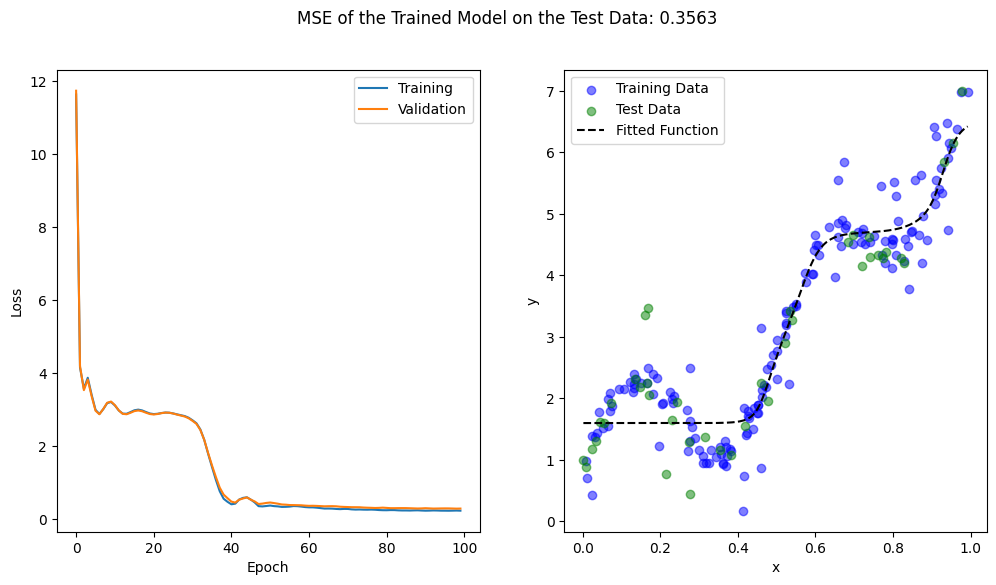

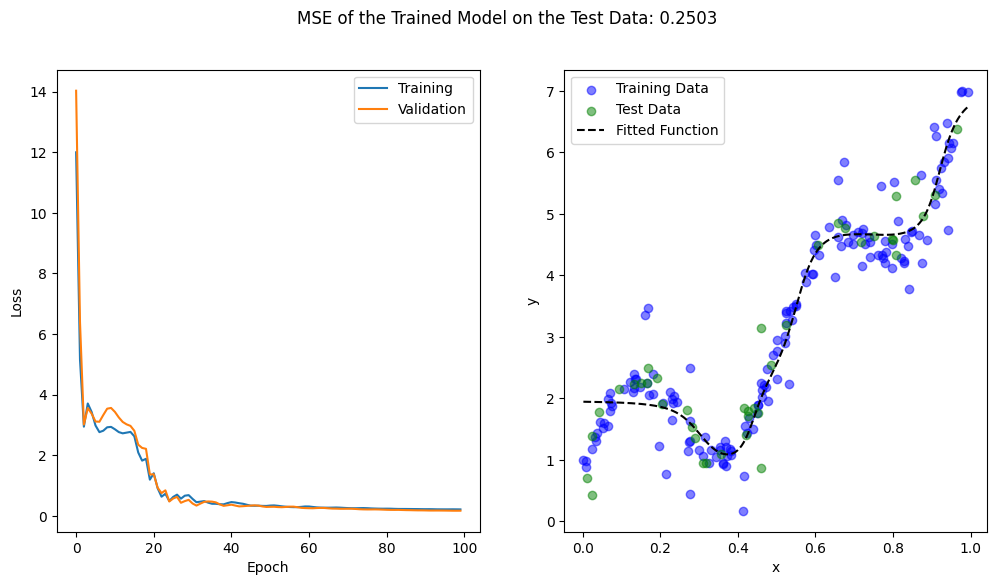

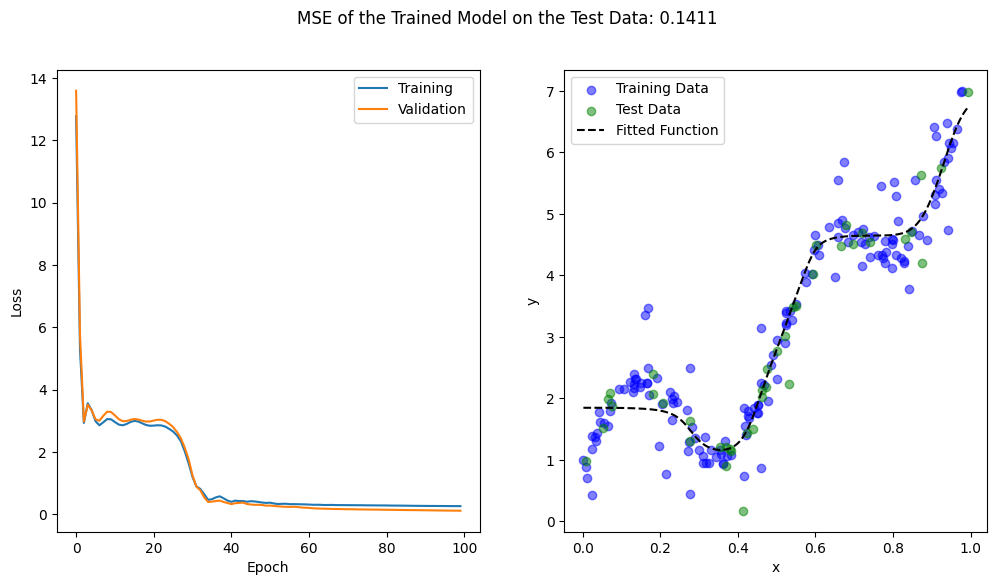

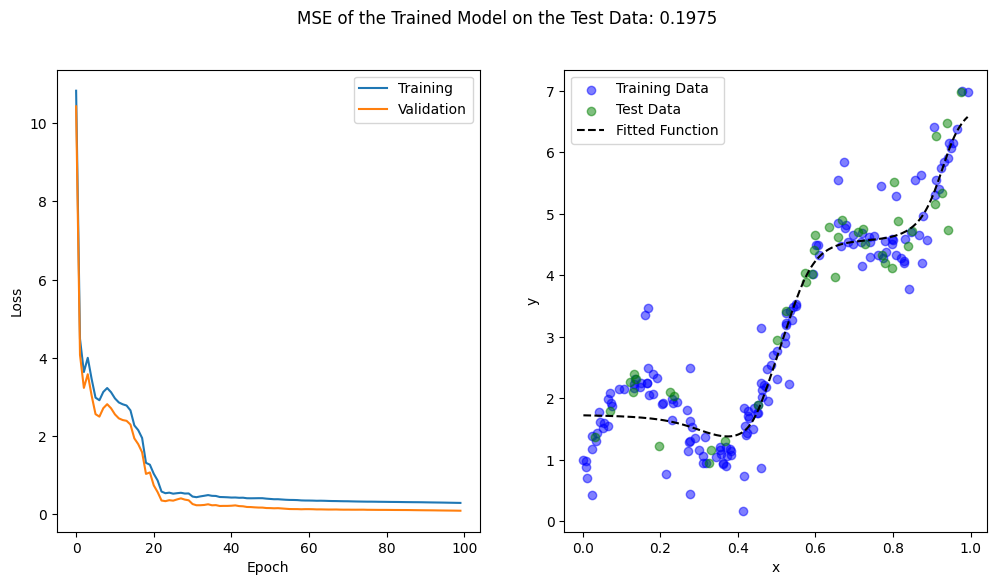

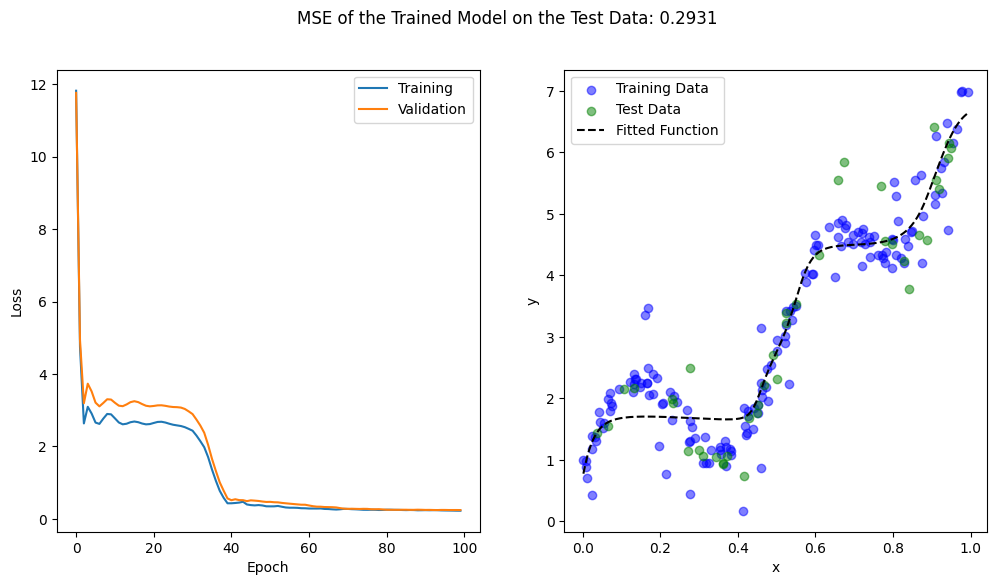

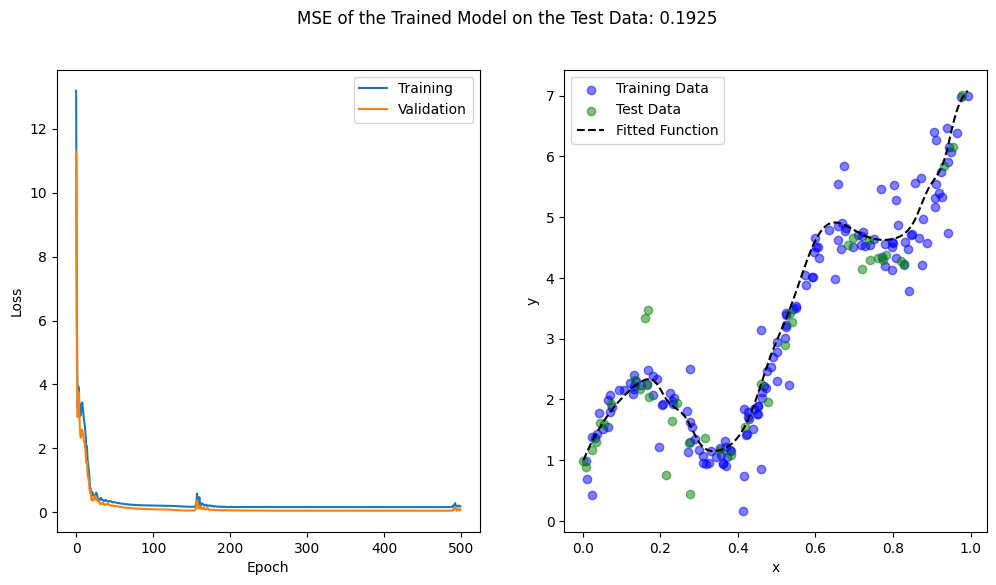

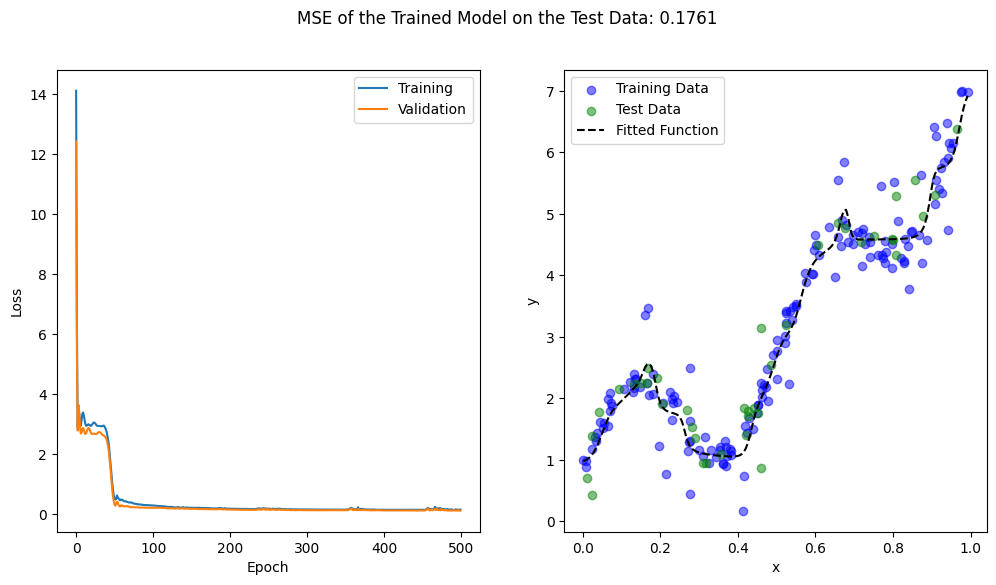

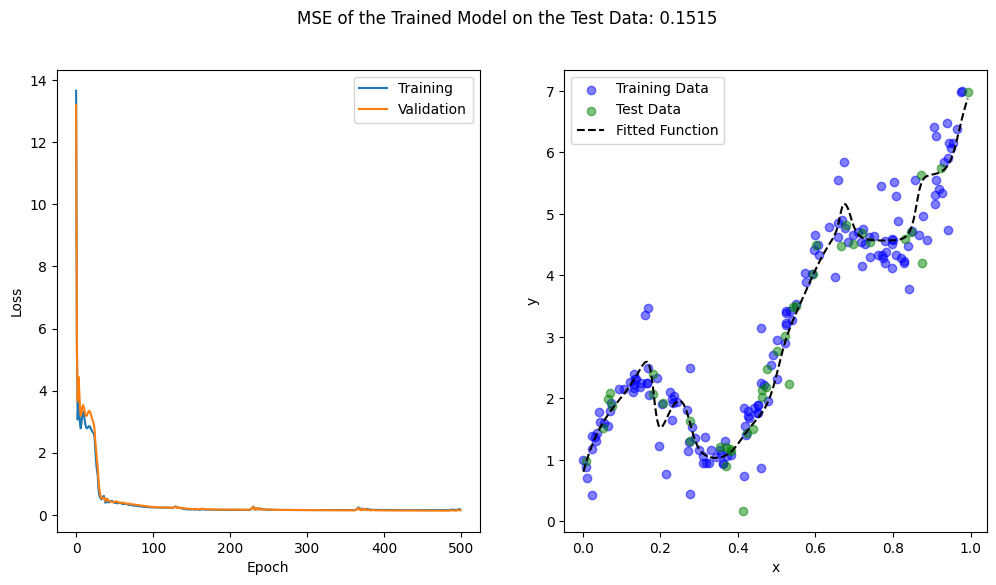

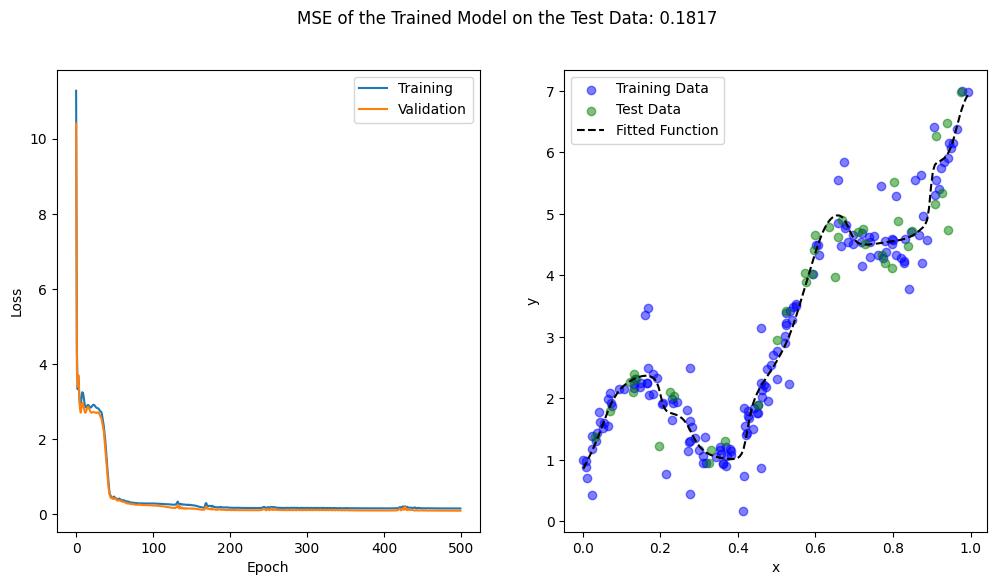

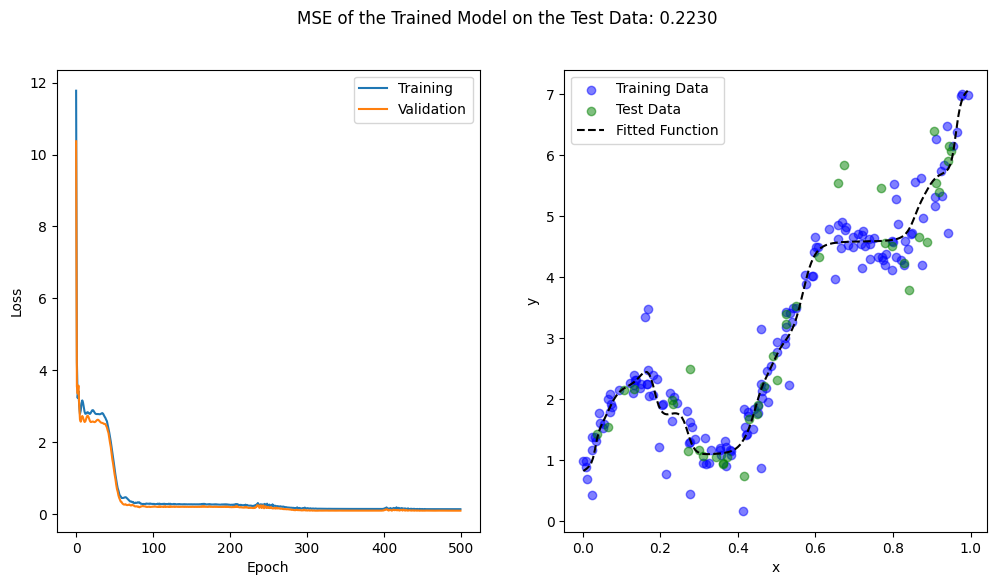

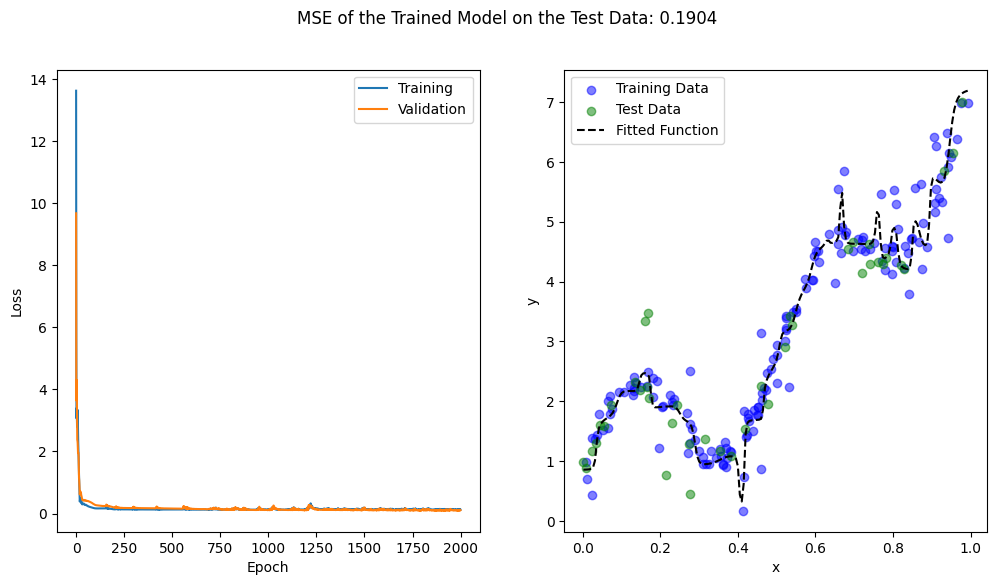

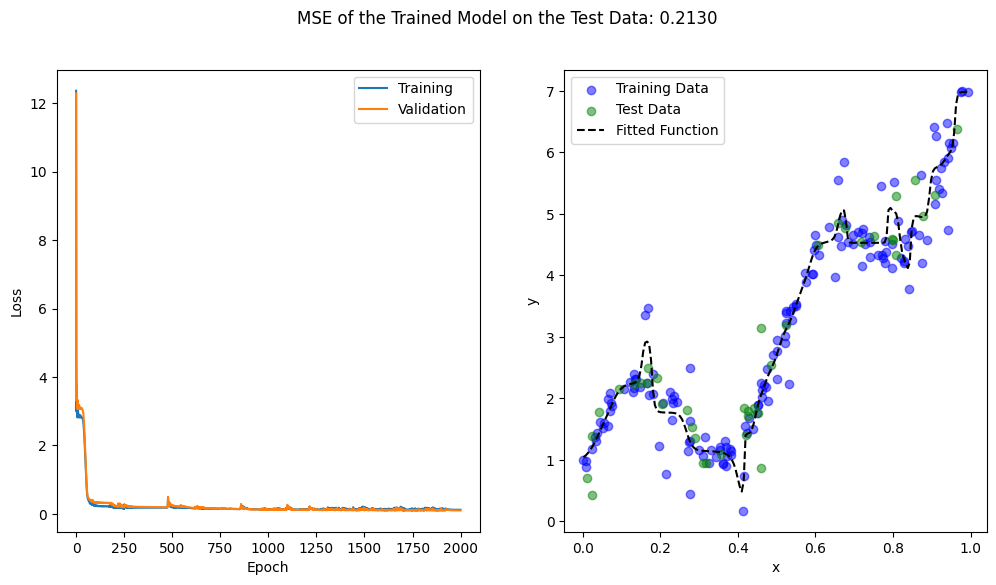

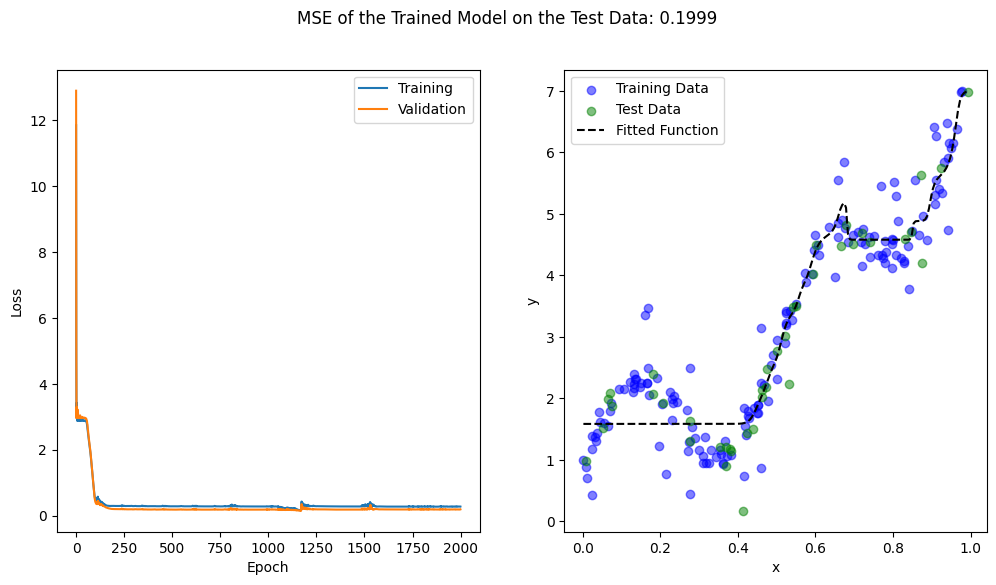

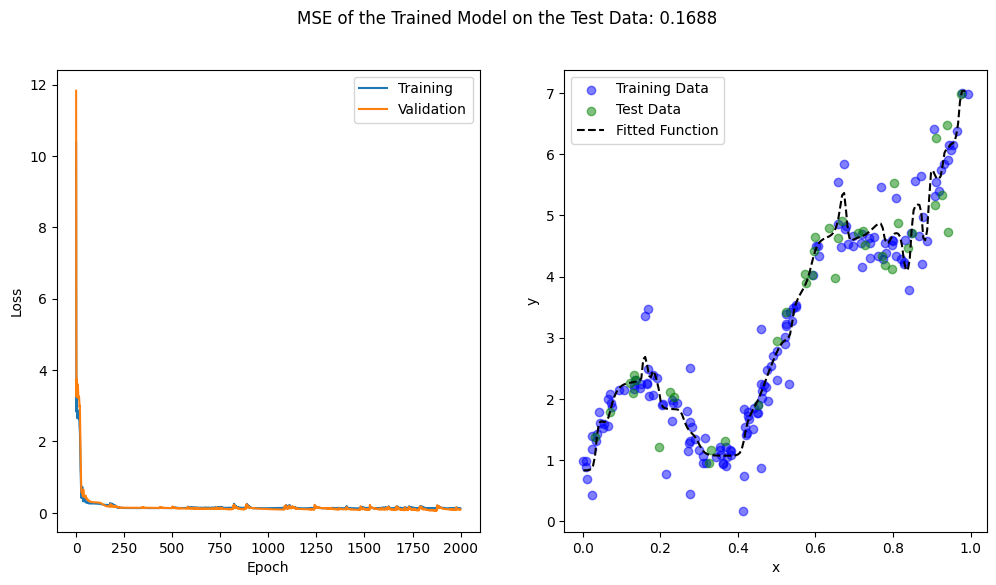

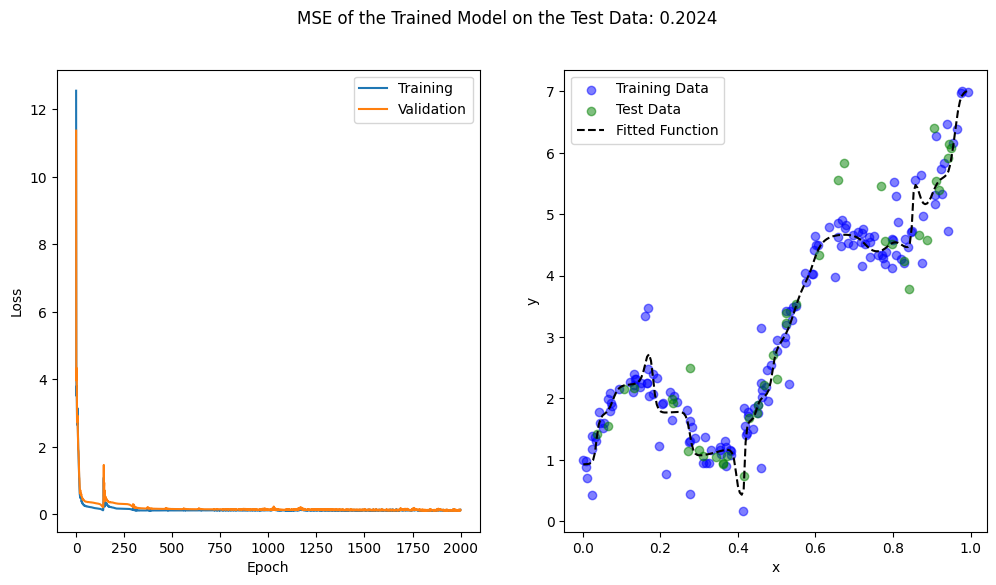

MSE for model trained for 100 epochs: 0.2477
MSE for model trained for 500 epochs: 0.1850
MSE for model trained for 2000 epochs: 0.1949


In [105]:
## YOUR CODE GOES HERE
from sklearn.base import clone

def crossValidation(x, y):
    folds = KFold(n_splits=5, random_state=0, shuffle=True)
    n_epochs = [100, 500, 2000]
    lossfun = nn.MSELoss()
    models_mse = []

    for n_epoch in n_epochs:
        model_mses = []
        for train_idx, test_idx in folds.split(x):
            x_train, x_test = x[train_idx], x[test_idx]
            y_train, y_test = y[train_idx], y[test_idx]
            x_train_tensor = torch.tensor(x_train).reshape(-1,1).float()
            x_test_tensor = torch.tensor(x_test).reshape(-1,1).float()
            y_train_tensor = torch.tensor(y_train).reshape(-1,1).float()

            model, train_curve, val_curve = NeuralNetwork.trainModel(x_train, y_train, n_epoch)
            model.eval()
            yhat = model(x_test_tensor)
            mse = lossfun(yhat, y_test).item()
            model_mses.append(mse)

            fig, ax = plt.subplots(1, 2, figsize=(12, 6))
            plotLoss(ax[0], train_curve, val_curve)
            plotModel(ax[1], model, x, y, train_idx, test_idx)
            plt.suptitle(f'MSE of the Trained Model on the Test Data: {model_mses[-1]:.4f}')
            plt.show()

        models_mse.append(np.mean(model_mses))

    return models_mse

# cross validation for 100, 500, 2000 epochs
n_epochs = [100, 500, 2000]
models_mse = crossValidation(x, y)
for i, mse in enumerate(models_mse):
    print(f"MSE for model trained for {n_epochs[i]} epochs: {mse:.4f}")
# print("MSE for each model (100, 500, 2000):", models_mse)

## Discussion

Compare the averaged MSE result for the three different models, and comment on which number of epochs is most optimal. Why is it important that we perform cross validation when evaluating a model? For a given number of epochs, are all 5 of the k-fold models similar, or is there significant variation? Are some models underfit, overfit?

*Your response goes here*

For the model trained for 100 epochs, the average MSE is around 0.2477. For the model trained for 500 epochs, the average MSE is around 0.1850. For the model trained for 2000 epochs, the average MSE is around 0.1949. From the above results, the average MSE performance can be ranked from best to worst as the following: 500 epochs, 2000 epochs, and 100 epochs. The most optimal number of epochs would be 500 epochs. 

It is important to perform cross-validation when evaluating a model because it helps the model reduce the tendency of overfitting. It also gives us a better idea of our model's prediction compared to unseen data.

For a given number of epochs, there can be slight variations depending on the subsets of data used in each fold. However, the variation should not be significant. Models trained for 100 epochs show indications of underfitting. On the other hand, models trained for 2000 epochs show indications of overfitting. 